In [558]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import seaborn as sns
from datetime import date
import yfinance as yf
from datetime import datetime, timedelta

In [559]:
def realizagranger(df, maxlag=6, epsilon=0.01, sel1="HRV", sel2="HRV"):
    try:
        if len(df) <= maxlag:
            
            print(f"{len(df)} Datos insuficientes?.")
            return 0
        
        # Realizar la prueba de causalidad de Granger
        gc_test_1 = grangercausalitytests(df[[sel1, sel2]], maxlag=maxlag, verbose=False);
        p_values = [gc_test_1[i + 1][0]['ssr_chi2test'][1] for i in range(maxlag)]
        
        # Verificar si la media de los p-valores es menor que el umbral
        for val in p_values:
            if val < epsilon:
                return 1
        return 0
        #return int(np.mean(p_values) < pval)
        
    except Exception as e:
        print(f"Error en ventana {e}")
        return 0

def crea_matriz(df, maxlag=6, epsilon=0.01):
    matriz = np.zeros((df.shape[1], df.shape[1]))
    for i in range(df.shape[1]):
        for j in range(df.shape[1]):
            if i != j:
                matriz[i, j] = realizagranger(df, sel1=df.columns[i], sel2=df.columns[j], maxlag=maxlag, epsilon=epsilon)
    return matriz

In [560]:
df_precios = pd.DataFrame()

# Acciones
activos = ['ALSEA.MX','GRUMAB.MX','GCARSOA1.MX', 'AMXB.MX', 'CUERVO.MX', 'GCC.MX', 'TLEVISACPO.MX', 
          'GFINBURO.MX','KOFUBL.MX','HERDEZ.MX', 'Q.MX', 'BIMBOA.MX', 'RA.MX' ]

# Numero de acciones
n = len(activos)

today = date.today()
start = today - timedelta(days=20)

print(today)

for i in activos:
    df_precios[i] = pd.DataFrame(yf.Ticker(i).history(start = start,end = today, )['Close'])
    
df_precios.head(10)
df_precios.fillna(method='ffill', inplace=True)

2024-12-27


C:\Users\fercy\AppData\Local\Temp\ipykernel_25556\3472183278.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_precios.fillna(method='ffill', inplace=True)


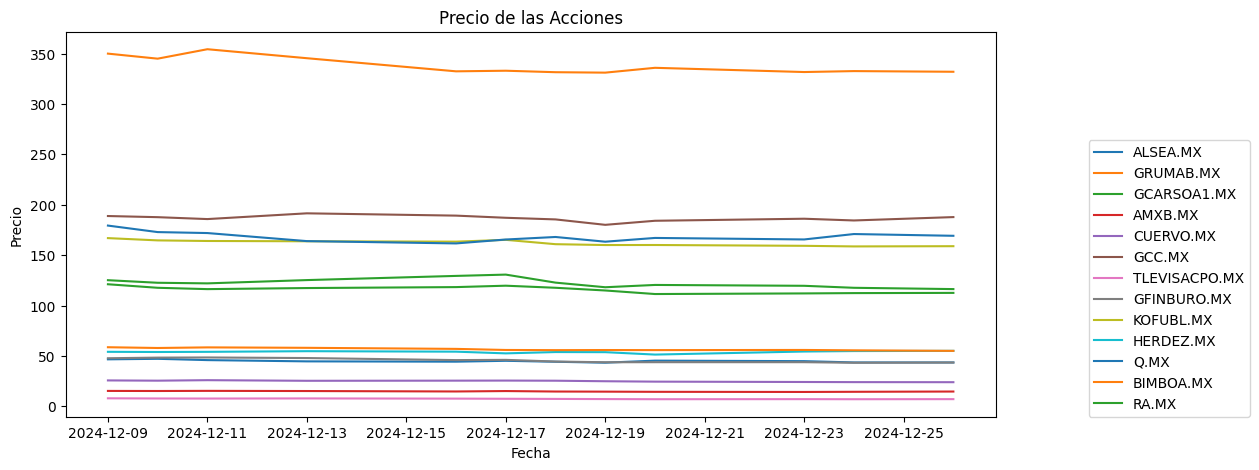

In [561]:
plt.figure(figsize = (12,5))
for i in df_precios.columns.values:
    plt.plot(df_precios[i], label = i)
plt.title('Precio de las Acciones')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend(df_precios.columns.values, loc = [1.1,0])
plt.show()

In [562]:
import networkx as nx

# Selección de rasgos

Los rasgos seleccionados serán:
* El nodo que tenga más inputs
* Los activos que estén conectados a ese nodo

Se tomarán ventanas de señal del triple del maxlag y predecir al menos 5 días después.

In [563]:
matriz_causalidad = crea_matriz(df_precios, maxlag = 3, epsilon = 0.01);

c:\Users\fercy\miniconda3\envs\ibero\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\fercy\miniconda3\envs\ibero\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\fercy\miniconda3\envs\ibero\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\fercy\miniconda3\envs\ibero\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\fercy\miniconda3\envs\ibero\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\fercy\miniconda3\envs\ibero\Lib\site-packages\statsmodels\tsa\stat

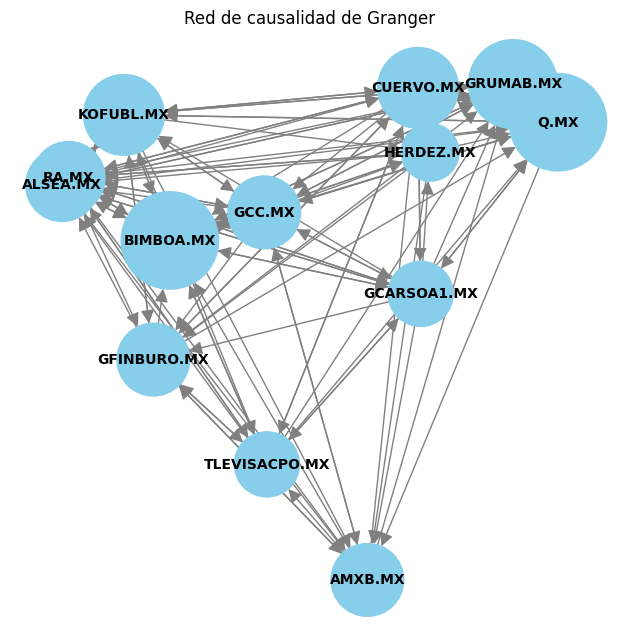

In [564]:
G = nx.DiGraph()  

labels = df_precios.columns

for i in range(len(matriz_causalidad)):
    for j in range(len(matriz_causalidad[i])):
        if matriz_causalidad[i][j] == 1:  
            G.add_edge(labels[i], labels[j])

for label in labels:
    if label not in G:
        G.add_node(label)

in_degrees = dict(G.in_degree())
node_sizes = [(in_degrees[node] + 6) ** 3 for node in G.nodes()]  

plt.figure(figsize=(6, 6))
pos = nx.random_layout(G) 
nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray', arrows=True, arrowsize=20)
plt.title('Red de causalidad de Granger')
plt.show()

## Rasgos seleccionados

In [565]:
top_3 = sorted(in_degrees, key=in_degrees.get, reverse=True)[:3]
connected_nodes = {node: list(G.predecessors(node)) for node in top_3}


In [566]:
print(f"Los nodos conectados a {top_3[1]} son: {connected_nodes[top_3[1]]}")

Los nodos conectados a BIMBOA.MX son: ['ALSEA.MX', 'GRUMAB.MX', 'GCARSOA1.MX', 'AMXB.MX', 'CUERVO.MX', 'GCC.MX', 'TLEVISACPO.MX', 'GFINBURO.MX', 'KOFUBL.MX', 'HERDEZ.MX', 'RA.MX']


In [567]:
df_rasgos = pd.DataFrame()

activos_seleccionados = [top_3[1]] + connected_nodes[top_3[1]]
# Numero de acciones
n = len(activos)

today = date.today()
start = today - timedelta(days=80)

print(today)

for i in activos_seleccionados:
    df_rasgos[i] = pd.DataFrame(yf.Ticker(i).history(start = start,end = today, )['Close'])
    df_rasgos[i] = (df_rasgos[i] - df_rasgos[i].mean()) / df_rasgos[i].std()
df_rasgos.head(2)
df_rasgos.fillna(method='ffill', inplace=True)

2024-12-27


C:\Users\fercy\AppData\Local\Temp\ipykernel_25556\789041974.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_rasgos.fillna(method='ffill', inplace=True)


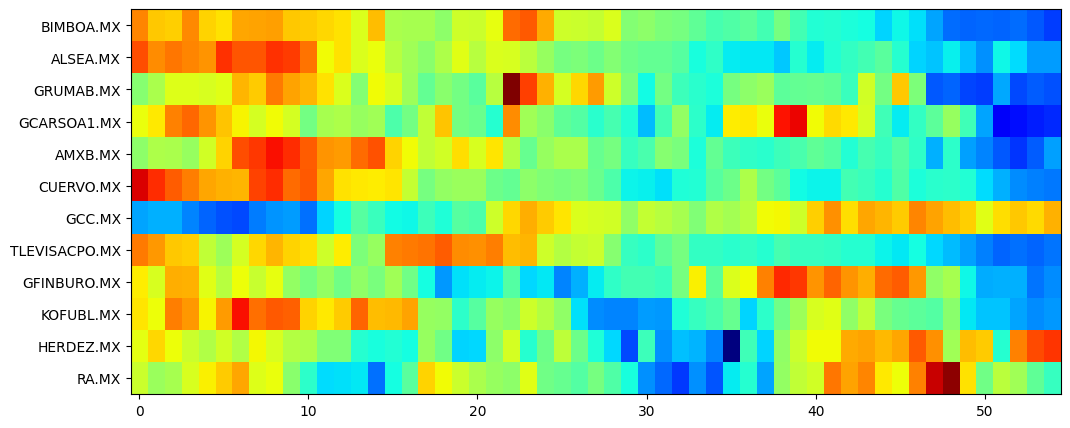

In [568]:
plt.figure(figsize = (12,5))
plt.imshow(df_rasgos.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.yticks(range(len(df_rasgos.columns)), df_rasgos.columns);

In [569]:
def genera_grupos_activos(df_train, len_sec=12, train_split=0.2, output='binary', step=2, random=False, future_win = 4):
    X = df_train.values
    y = df_train[output].values
    X_seq = []
    y_seq = []

    for i in range(0, len(X) - len_sec, step):
        if i + len_sec + future_win > len(X):
            break
        X_seq.append(X[i:i+len_sec])
        y_seq.append(y[i+len_sec:i+len_sec+future_win])
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    if not random:
        long2 = X_seq.shape[0]
        split_index = int(long2 * train_split)

        X_train = X_seq[:split_index, :, :]
        y_train = y_seq[:split_index, :]

        X_test = X_seq[split_index:, :, :]
        y_test = y_seq[split_index:, :]
    else:
        indices = np.arange(X_seq.shape[0])
        np.random.shuffle(indices)
        
        X_seq = X_seq[indices]
        y_seq = y_seq[indices]
        split_index = int(X_seq.shape[0] * train_split)
        
        X_train = X_seq[:split_index, :, :]
        y_train = y_seq[:split_index, :]
        X_test = X_seq[split_index:, :, :]
        y_test = y_seq[split_index:, :]

    return X_train, y_train, X_test, y_test

In [570]:
X_train, y_train, X_test, y_test = genera_grupos_activos(df_rasgos, len_sec=15, train_split=0.8, output=top_3[1], step=1, random=True)

In [571]:
y_train.shape

(29, 4)

Text(0.5, 0, 'Tiempo')

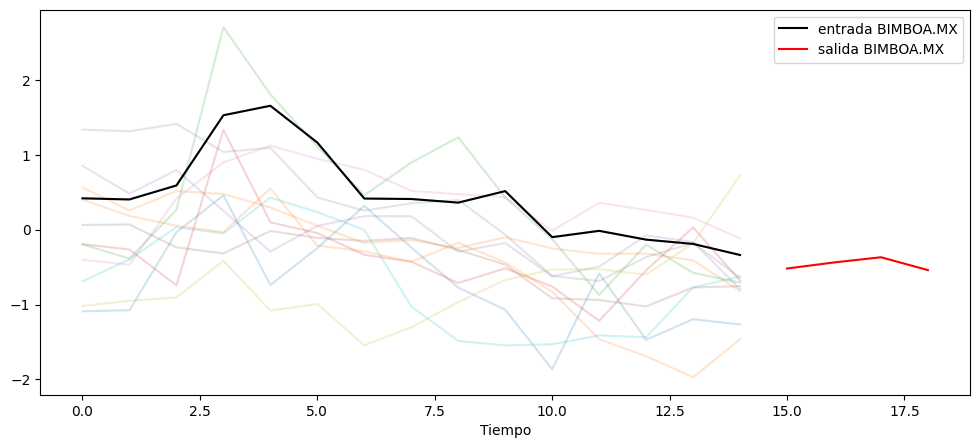

In [572]:
t = np.arange(0, X_train.shape[1], 1)
t2 = np.arange(X_train.shape[1], X_train.shape[1] + y_train.shape[1], 1)

plt.figure(figsize=(12, 5))
plt.plot(t, X_train[y_train.shape[1]], alpha=0.2)
plt.plot(t, X_train[y_train.shape[1], :, 0], 'k', label=f'entrada {top_3[1]}')

plt.plot(t2, y_train[y_train.shape[1]], 'r', label=f'salida {top_3[1]}')
plt.legend()
plt.xlabel('Tiempo')

## Creación del modelo

In [573]:
import tensorflow as tf

from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.layers import MultiHeadAttention

from tensorflow.keras.models import Model, Sequential

In [574]:
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, r2_score
from keras.layers import InputLayer
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

import tensorflow as tf
from tensorflow.keras.layers import InputLayer, LSTM, Conv1D, MaxPooling1D, Flatten, Dense

In [575]:

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

x = LSTM(16, return_sequences=True)(inputs)
x = Dropout(0.2)(x)
x = LSTM(8, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = LSTM(4, return_sequences=True)(x)

attention_output = MultiHeadAttention(num_heads=4, key_dim=16)(x, x)

x = Flatten()(attention_output)

x = Dense(16, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(8, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(4, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
outputs = Dense(y_train.shape[1], activation='tanh')(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 15, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_51 (LSTM)      │ (None, 15, 16)    │      1,856 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_85          │ (None, 15, 16)    │          0 │ lstm_51[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_52 (LSTM)      │ (None, 15, 8)     │        800 │ dropout_85[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_86          │ (None, 15, 8)     │          0 │ lstm_52[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_53 (LSTM)      │ (None, 15, 4)     │        208 │ dropout_86[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 4)     │      1,220 │ lstm_53[0][0],    │
│ (MultiHeadAttentio… │                   │            │ lstm_53[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_17          │ (None, 60)        │          0 │ multi_head_atten… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_65 (Dense)    │ (None, 16)        │        976 │ flatten_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_88          │ (None, 16)        │          0 │ dense_65[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 8)         │        136 │ dropout_88[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_89          │ (None, 8)         │          0 │ dense_66[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_67 (Dense)    │ (None, 4)         │         36 │ dropout_89[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_68 (Dense)    │ (None, 4)         │         20 │ dense_67[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,252 (20.52 KB)

 Trainable params: 5,252 (20.52 KB)

 Non-trainable params: 0 (0.00 B)

In [576]:

cp4 = ModelCheckpoint('model/test.keras', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=[RootMeanSquaredError(), 'mae'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3000, callbacks=[cp4, early_stopping])

Epoch 1/3000


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 1.3039 - mae: 0.7548 - root_mean_squared_error: 0.9261 - val_loss: 1.4057 - val_mae: 0.7506 - val_root_mean_squared_error: 0.9808
Epoch 2/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.2960 - mae: 0.7521 - root_mean_squared_error: 0.9231 - val_loss: 1.3840 - val_mae: 0.7416 - val_root_mean_squared_error: 0.9709
Epoch 3/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 1.2653 - mae: 0.7401 - root_mean_squared_error: 0.9077 - val_loss: 1.3602 - val_mae: 0.7313 - val_root_mean_squared_error: 0.9598
Epoch 4/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 1.2459 - mae: 0.7330 - root_mean_squared_error: 0.8983 - val_loss: 1.3344 - val_mae: 0.7194 - val_root_mean_squared_error: 0.9475
Epoch 5/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 1.2466 - mae: 0.7322 - root_mean_squared_error: 0.8999 - val_loss: 1.3088 - val_mae: 0.7071 - val_root_mean_squared_error: 0.9351
Epoch 6/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 1.2157

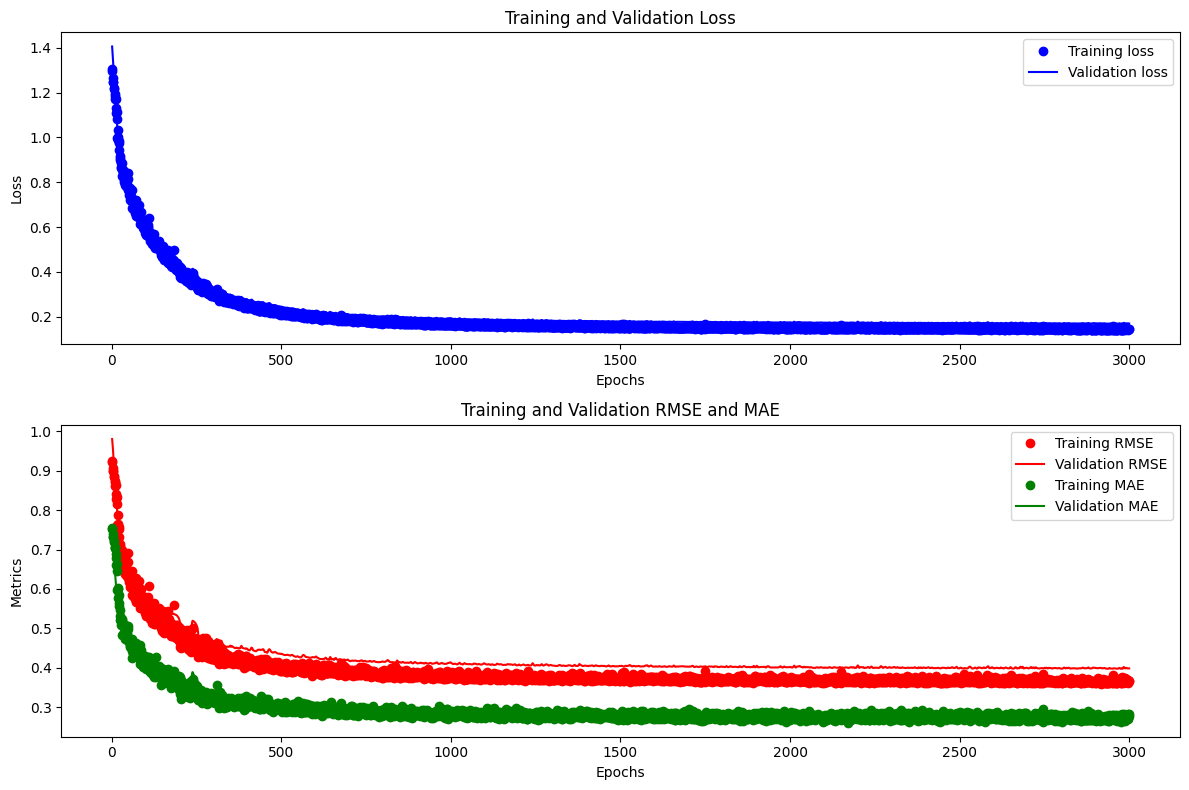

In [577]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
rmse = history_dict['root_mean_squared_error']
val_rmse = history_dict['val_root_mean_squared_error']
mae = history_dict['mae']
val_mae = history_dict['val_mae']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, rmse, 'ro', label='Training RMSE')
plt.plot(epochs, val_rmse, 'r', label='Validation RMSE')
plt.plot(epochs, mae, 'go', label='Training MAE')
plt.plot(epochs, val_mae, 'g', label='Validation MAE')
plt.title('Training and Validation RMSE and MAE')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()

plt.tight_layout()
plt.show()

In [578]:
X_train, y_train, X_test, y_test = genera_grupos_activos(df_rasgos, len_sec=15, train_split=0.2, output=top_3[1], step=1, random=False)

In [579]:
X_test.shape

(30, 15, 12)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


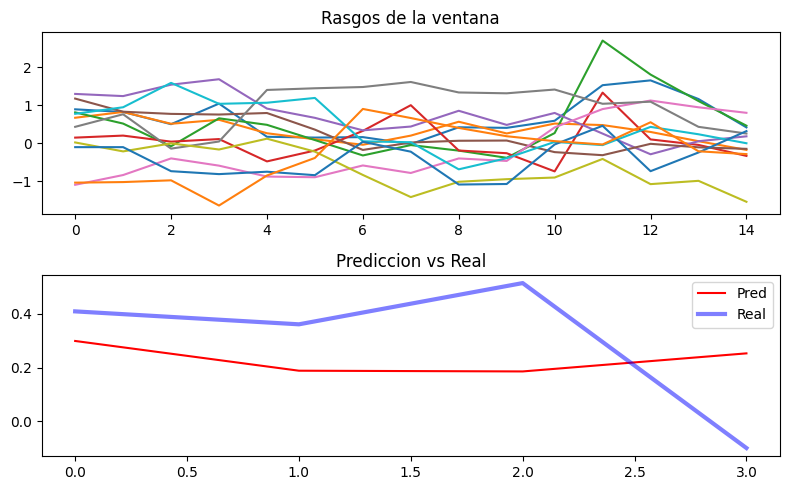

In [580]:
index_window = 4

y_pred = model.predict(X_test[index_window, :, :][np.newaxis, :, :])


plt.figure(figsize=(8, 5))

plt.subplot(2, 1, 1)
for i in range(X_test.shape[2]):
    plt.plot(X_test[index_window, :, i], label=df_rasgos.columns[i])

plt.title('Rasgos de la ventana')

plt.subplot(2, 1, 2)
plt.plot(y_pred[0,:], label='Pred', color='red')
plt.plot(y_test[index_window,:], label='Real', color='blue', alpha=0.5, linewidth=3)

plt.legend()
plt.title('Prediccion vs Real')

plt.tight_layout()
plt.show()

In [581]:
y_pred = model.predict(X_test[:, :, :])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


In [582]:
y_pred.shape

(30, 4)

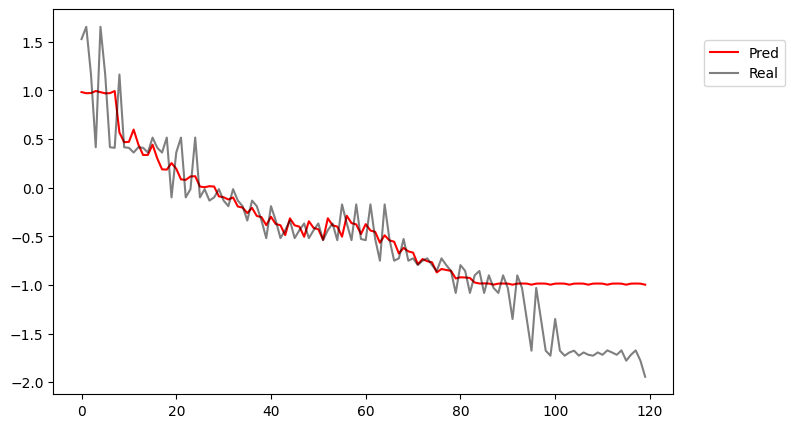

In [583]:
plt.figure(figsize=(8, 5))
plt.plot(y_pred[:, :].flatten(), label='Pred', color='red')
plt.plot(y_test[:, :].flatten(), label='Real', color='k', alpha=0.5)
plt.legend(loc=[1.05, 0.8])